<a href="https://colab.research.google.com/github/CIA-Oceanix/DLCourse_MOi_2022/blob/main/notebooks/notebook_Pytorch_Weak4DVar_L63.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook for the implementation of model-based inversion scheme**: Application to the Data Assimilation of Lorenz-63 dynamics given noisy and partial observations.

We consider model-based formulation based on the following variational minimization
$$\arg \min_x \| x - y\|^2_\Omega + \lambda \|x-\Phi(x)\|^2 $$

The notebook addresses two approaches which differ in the considered prior $\Phi$
*   *Weak-Constrained 4DVar formulation* with the true ODE-based prior: Pytorch implementation of the gradient descent. You need to code the computation of the gradient of tha variational cost using automatic differentiation tool.
*   *Exploration of a pretrained plug-and-play prior*: Pytorch gradient descent with a PCA-based prior. You need to compute the loss for such a PCA-based prior. 

*Possible extensions*: (i) evaluation of the reconstruction performance depending on the considered observation setting (i.e., sampling and noise), (ii) intercomparison of different types of plug-and-play


In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import tensorflow.keras as keras

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition
from sklearn.feature_extraction import image

In [ ]:
!pip install torchviz
import torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=c5002f8069a283a176624f6026fcb25ab4f2e0774a80d2032f5cf1317bc859c3
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


# L63 Data simulation

(10000, 3)


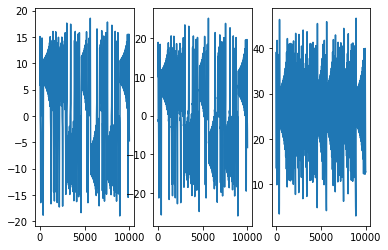

In [6]:
#os.chdir('/content/drive/My Drive/Colab Notebooks/AnDA')
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
#from AnDA_codes.AnDA_dynamical_models import AnDA_Lorenz_63, AnDA_Lorenz_96

def AnDA_Lorenz_63(S,t,sigma,rho,beta):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1]-S[0]);
    x_2 = S[0]*(rho-S[2])-S[1];
    x_3 = S[0]*S[1] - beta*S[2];
    dS  = np.array([x_1,x_2,x_3]);
    return dS

class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8 # number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1,2]) # indices of the observed variables
    nb_loop_train = 10**2 # size of the catalog
    nb_loop_test = 10000 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation

GD = GD()    
y0 = np.array([8.0,0.0,30.0])
tt = np.arange(GD.dt_integration,GD.nb_loop_test*GD.dt_integration+0.000001,GD.dt_integration)
#S = odeint(AnDA_Lorenz_63,x0,np.arange(0,5+0.000001,GD.dt_integration),args=(GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta));
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta),t_span=[0.,5+0.000001],y0=y0,first_step=GD.dt_integration,t_eval=np.arange(0,5+0.000001,GD.dt_integration),method='RK45')

y0 = S.y[:,-1];
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta),t_span=[0.01,GD.nb_loop_test+0.000001],y0=y0,first_step=GD.dt_integration,t_eval=tt,method='RK45')
S = S.y.transpose()

print(S.shape)
plt.figure(1)
for jj in range(0,3):
  plt.subplot(131+jj)
  plt.plot(S[:,jj])
  
class time_series:
  values = 0.
  time   = 0.
  
xt = time_series()
xt.values = S
xt.time   = tt

In [7]:
####################################################
## Generation of training and test dataset
## Extraction of time series of dT time steps            
NbTraining = 10000
NbTest     = 2000#256
time_step = 1
dT        = 200
sigNoise  = np.sqrt(2.0)
rateMissingData = (1-1./8.)#0.75#0.95
  
xt = time_series()
xt.values = S
xt.time   = tt
# extract subsequences
dataTrainingNoNaN = image.extract_patches_2d(xt.values[0:7500:time_step,:],(dT,3),max_patches=NbTraining)
dataTestNoNaN     = image.extract_patches_2d(xt.values[8000::time_step,:],(dT,3),max_patches=NbTest)

# create missing data
flagTypeMissData = 1
if flagTypeMissData == 0:
    print('..... Observation pattern: Random sampling of osberved L63 components')
    indRand         = np.random.permutation(dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTraining    = np.copy(dataTrainingNoNaN).reshape((dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2],1))
    dataTraining[indRand] = float('nan')
    dataTraining    = np.reshape(dataTraining,(dataTrainingNoNaN.shape[0],dataTrainingNoNaN.shape[1],dataTrainingNoNaN.shape[2]))
    
    indRand         = np.random.permutation(dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTest        = np.copy(dataTestNoNaN).reshape((dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2],1))
    dataTest[indRand] = float('nan')
    dataTest          = np.reshape(dataTest,(dataTestNoNaN.shape[0],dataTestNoNaN.shape[1],dataTestNoNaN.shape[2]))

    genSuffixObs    = '_ObsRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
elif flagTypeMissData == 2:
    print('..... Observation pattern: Only the first L63 component is osberved')
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTraining    = np.zeros((dataTrainingNoNaN.shape))
    dataTraining[:] = float('nan')
    dataTraining[:,::time_step_obs,0] = dataTrainingNoNaN[:,::time_step_obs,0]
    
    dataTest    = np.zeros((dataTestNoNaN.shape))
    dataTest[:] = float('nan')
    dataTest[:,::time_step_obs,0] = dataTestNoNaN[:,::time_step_obs,0]

    genSuffixObs    = '_ObsDim0_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
   
else:
    print('..... Observation pattern: All  L63 components osberved')
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTraining    = np.zeros((dataTrainingNoNaN.shape))
    dataTraining[:] = float('nan')
    dataTraining[:,::time_step_obs,:] = dataTrainingNoNaN[:,::time_step_obs,:]
    
    dataTest    = np.zeros((dataTestNoNaN.shape))
    dataTest[:] = float('nan')
    dataTest[:,::time_step_obs,:] = dataTestNoNaN[:,::time_step_obs,:]

    genSuffixObs    = '_ObsSub_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
    
# set to NaN patch boundaries
dataTraining[:,0:10,:] =  float('nan')
dataTest[:,0:10,:]     =  float('nan')
dataTraining[:,dT-10:dT,:] =  float('nan')
dataTest[:,dT-10:dT,:]     =  float('nan')

# mask for NaN
maskTraining = (dataTraining == dataTraining).astype('float')
maskTest     = ( dataTest    ==  dataTest   ).astype('float')

dataTraining = np.nan_to_num(dataTraining)
dataTest     = np.nan_to_num(dataTest)

# Permutation to have channel as #1 component
dataTraining      = np.moveaxis(dataTraining,-1,1)
maskTraining      = np.moveaxis(maskTraining,-1,1)
dataTrainingNoNaN = np.moveaxis(dataTrainingNoNaN,-1,1)

dataTest      = np.moveaxis(dataTest,-1,1)
maskTest      = np.moveaxis(maskTest,-1,1)
dataTestNoNaN = np.moveaxis(dataTestNoNaN,-1,1)

# set to NaN patch boundaries
#dataTraining[:,0:5,:] =  dataTrainingNoNaN[:,0:5,:]
#dataTest[:,0:5,:]     =  dataTestNoNaN[:,0:5,:]

############################################
## raw data
X_train         = dataTrainingNoNaN
X_train_missing = dataTraining
mask_train      = maskTraining

X_test         = dataTestNoNaN
X_test_missing = dataTest
mask_test      = maskTest

############################################
## normalized data
meanTr          = np.mean(X_train_missing[:]) / np.mean(mask_train) 
stdTr           = np.sqrt( np.mean( (X_train_missing-meanTr)**2 ) / np.mean(mask_train) )

if flagTypeMissData == 2:
    meanTr          = np.mean(X_train[:]) 
    stdTr           = np.sqrt( np.mean( (X_train-meanTr)**2 ) )

x_train_missing = ( X_train_missing - meanTr ) / stdTr
x_test_missing  = ( X_test_missing - meanTr ) / stdTr

# scale wrt std

x_train = (X_train - meanTr) / stdTr
x_test  = (X_test - meanTr) / stdTr

print('.... MeanTr = %.3f --- StdTr = %.3f '%(meanTr,stdTr))

# Generate noisy observsation
X_train_obs = X_train_missing + sigNoise * maskTraining * np.random.randn(X_train_missing.shape[0],X_train_missing.shape[1],X_train_missing.shape[2])
X_test_obs  = X_test_missing  + sigNoise * maskTest * np.random.randn(X_test_missing.shape[0],X_test_missing.shape[1],X_test_missing.shape[2])

x_train_obs = (X_train_obs - meanTr) / stdTr
x_test_obs  = (X_test_obs - meanTr) / stdTr

print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))


..... Observation pattern: All  L63 components osberved
.... MeanTr = 8.527 --- StdTr = 27.852 
..... Training dataset: 7301x3x200
..... Test dataset    : 1801x3x200


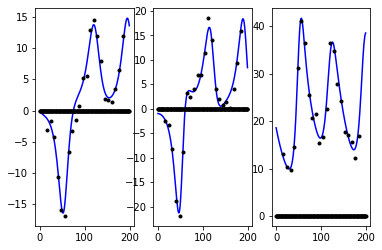

In [8]:
# Visualisation
plt.figure(1)
for jj in range(0,3):
  indjj = 131+jj
  plt.subplot(indjj)
  plt.plot(X_train[20,jj,:],'b-')
  plt.plot(X_train_obs[20,jj,:],'k.')

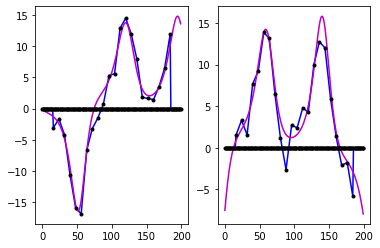

In [9]:
# Initial interpolation (linear interpolation or zeros) for missing data

import scipy

mx_train = np.sum( np.sum( X_train , axis = 2 ) , axis = 0 ) / (X_train.shape[0]*X_train.shape[2])

flagInit = 1

if flagInit == 0: 
  X_train_Init = mask_train * X_train_obs + (1. - mask_train) * (np.zeros(X_train_missing.shape) + meanTr)
  X_test_Init  = mask_test * X_test_obs + (1. - mask_test) * (np.zeros(X_test_missing.shape) + meanTr)
else:
  X_train_Init = np.zeros(X_train.shape)
  for ii in range(0,X_train.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_train.shape[1],X_train.shape[2]))

    for kk in range(0,3):
      indt  = np.where( mask_train[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_train[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_train_obs[ii,kk,indt])
        XInit[kk,indt]  = X_train_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit[kk,:] = XInit[kk,:] + mx_train[kk]

    X_train_Init[ii,:,:] = XInit

  X_test_Init = np.zeros(X_test.shape)
  for ii in range(0,X_test.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_test.shape[1],X_test.shape[2]))

    for kk in range(0,3):
      indt  = np.where( mask_test[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_test[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_test_obs[ii,kk,indt])
        XInit[kk,indt]  = X_test_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit[kk,:] = XInit[kk,:] + mx_train[kk]

    X_test_Init[ii,:,:] = XInit


x_train_Init = ( X_train_Init - meanTr ) / stdTr
x_test_Init = ( X_test_Init - meanTr ) / stdTr


if 1*1:
  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(X_train_Init[20,0,:],'b-')
  plt.plot(X_train[20,0,:],'m-')
  #plt.plot(XInit[:,0],'r-')
  plt.plot(X_train_obs[20,0,:],'k.')
  plt.subplot(1,2,2)
  plt.plot(X_test_Init[20,0,:],'b-')
  plt.plot(X_test[20,0,:],'m-')
  #plt.plot(XInit[:,0],'r-')
  plt.plot(X_test_obs[20,0,:],'k.')

# Explicit Euler ODE scheme in Pytorch



In [10]:
# define forward model (Euler)
class ODE_L63(torch.nn.Module):
    def __init__(self,sigma,rho,beta):
        super(ODE_L63, self).__init__()
        self.sigma = sigma
        self.rho   = rho
        self.beta  = beta

    def forward(self, x):
      x_1 = (self.sigma*(x[:,1]-x[:,0])).view(-1,1)
      x_2 = (x[:,0]*(self.rho-x[:,2])-x[:,1]).view(-1,1)
      x_3 = (x[:,0]*x[:,1] - self.beta*x[:,2]).view(-1,1)

      return torch.cat((x_1,x_2,x_3),dim=1)

In [97]:
ii = 10

# create torch tensors for observations and hidden states
XGT_torch  = torch.Tensor( X_train[ii,:,:].squeeze().transpose() )
YObs_torch = torch.Tensor( X_train_obs[ii,:,:].squeeze().transpose() )
M_torch    = torch.Tensor( mask_train[ii,:,:].squeeze().transpose() )

# Initialisation
X_torch    = torch.Tensor( X_train_Init[ii,:,:].squeeze().transpose() )

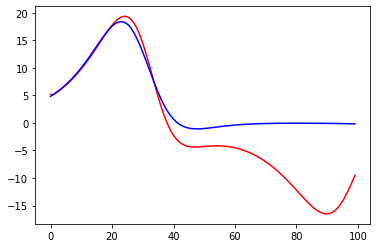

In [17]:
# check model simulation through an Euler integration scheme
ode_L63 = ODE_L63(10.,28.,8./3)

x0 = XGT_torch[0,:]
dt = 0.01

Xsim = []
for nn in range(0,100):
  if nn == 0:
    xt = x0
  xnew = xt + dt * ode_L63(xt.view(-1,3))
  if nn == 0:
    Xsim = xnew
  else:
    Xsim = torch.cat((Xsim,xnew),axis=0)
    xt   = xnew

plt.figure()
plt.plot(Xsim.cpu().detach().numpy()[:,1],'r-')
plt.plot(XGT_torch.cpu().detach().numpy()[0:100,1],'b-')

# (Weak-constrained) 4DVar DA  Pytorch 

In [101]:
# 4DVAR assimilation
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# assignment to GPU
ode_L63 = ODE_L63(10.,28.,8./3)
ode_L63 = ode_L63.to(device)

# assimilation loop
t0    = 0
dt    = 0.01
dT    = X_torch.size(0)
NIter = 20000
alpha_obs = 0.01
alpha_dyn = 1.
delta = 0.2

X_torch = torch.autograd.Variable(X_torch, requires_grad=True)
for iter in range(0,NIter):

  # compute losses
  with torch.set_grad_enabled(True): 
    # dynamical loss
    x_pred   = X_torch[t0:t0+dT-1,:] + dt * ode_L63(X_torch[t0:t0+dT-1,:])
    loss_dyn = torch.sum((X_torch[t0+1:t0+dT,:] - x_pred)**2 )

    # observation loss
    loss_obs = torch.sum((X_torch - YObs_torch)**2 * M_torch )

    # overall loss
    loss = alpha_obs * loss_obs + alpha_dyn * loss_dyn 

    if( np.mod(iter,100) == 0 ):
      print(".... iter %d: loss %.3f dyn_loss %.3f obs_loss %.3f"%(iter,loss,loss_dyn,loss_obs))  

    # compute gradient w.r.t. X and update X
    loss.backward()
    X_torch = X_torch - delta * X_torch.grad.data
    
    #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
    #X_torch = X_torch - delta * grad_X[0]
 
    X_torch = torch.autograd.Variable(X_torch, requires_grad=True)


.... iter 0: loss 1.673 dyn_loss 0.323 obs_loss 134.976
.... iter 100: loss 1.673 dyn_loss 0.323 obs_loss 134.978
.... iter 200: loss 1.673 dyn_loss 0.323 obs_loss 134.980
.... iter 300: loss 1.673 dyn_loss 0.323 obs_loss 134.982
.... iter 400: loss 1.673 dyn_loss 0.323 obs_loss 134.983
.... iter 500: loss 1.673 dyn_loss 0.323 obs_loss 134.985
.... iter 600: loss 1.673 dyn_loss 0.323 obs_loss 134.986
.... iter 700: loss 1.673 dyn_loss 0.323 obs_loss 134.988
.... iter 800: loss 1.673 dyn_loss 0.323 obs_loss 134.989
.... iter 900: loss 1.673 dyn_loss 0.323 obs_loss 134.991
.... iter 1000: loss 1.673 dyn_loss 0.323 obs_loss 134.992
.... iter 1100: loss 1.673 dyn_loss 0.323 obs_loss 134.994
.... iter 1200: loss 1.673 dyn_loss 0.323 obs_loss 134.995
.... iter 1300: loss 1.673 dyn_loss 0.323 obs_loss 134.996
.... iter 1400: loss 1.673 dyn_loss 0.323 obs_loss 134.997
.... iter 1500: loss 1.673 dyn_loss 0.323 obs_loss 134.998
.... iter 1600: loss 1.673 dyn_loss 0.323 obs_loss 134.999
.... iter

..... Assimilation performance
.. MSE ALL.   : 1.268 / 0.014
.. MSE ObsData: 0.867 / 0.009
.. MSE Interp : 1.318 / 0.014


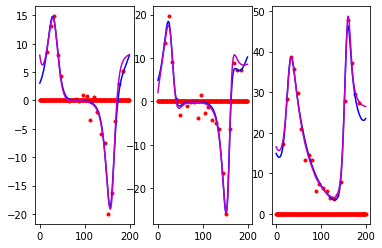

In [100]:
XGT  = XGT_torch.cpu().detach().numpy()[t0:t0+dT,:]
XHat = X_torch.cpu().detach().numpy()[t0:t0+dT,:]
M    = M_torch.cpu().detach().numpy()[t0:t0+dT,:]
YObs = YObs_torch.cpu().detach().numpy()[t0:t0+dT,:]

## visualization
plt.figure()
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  plt.plot(YObs[t0:t0+dT,kk],'r.')
  plt.plot(XGT[:,kk],'b-')
  plt.plot(XHat[:,kk],'m-')

# Reconstruction performance
varXGT  = np.mean( (XGT - np.mean(XGT,axis=0))**2 )
mse_All = np.mean( (XHat-XGT) **2 ) 
mse_I   = np.mean( (1.-M[t0:t0+dT,:]) * (XHat-XGT) **2 ) / np.mean( (1.-M[t0:t0+dT,:]) )
mse_R   = np.mean( M[t0:t0+dT,:] * (XHat-XGT) **2 ) / np.mean( M[t0:t0+dT,:] )

nmse_All = mse_All / varXGT
nmse_I   = mse_I / varXGT
nmse_R   = mse_R / varXGT

print("..... Assimilation performance")
print(".. MSE ALL.   : %.3f / %.3f"%(mse_All,nmse_All))
print(".. MSE ObsData: %.3f / %.3f"%(mse_R,nmse_R))
print(".. MSE Interp : %.3f / %.3f"%(mse_I,nmse_I))
